# Part 1: Analyze the network

The questions in this part are based on Lecture 5.

* Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
   - It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
   - I would like you to include concepts like centrality and assortativity in your analysis.
   - Use a network backbone in your analysis.
   - In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
   - **Note**: As I write above, an important part of the exercise consists is *selecting the right elements of the lecture* to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network.

To avoid downloading the pages again and again I saved the rock artists graph to a pickle file. I used our previous assignment to create the rock artists graph and then saved it to a pickle file.

For better code-readability we refactored our code into download_wikipedia_json.py, extract_wikipedia_text_to_string.py, get_artist_genres.py, sentiment_analysis.py and tfidf_communities.py. We also saved a pickle file of our graph from Assignment 1, so that it is easier to reconstruct the graph.
In the download_wikipedia_json.py we download the artists' wikipedia pages and save them as json files.
In the extract_wikipedia_text_to_string.py we extract the text of the wikipedia page from the json and cutting out references, HTML heathers, etc.
In the get_artist_genres.py we save the genre list of all the artists.
In the sentiment_analysis.py given a text we perform a sentiment_analysis on it.
In the tfidf_communities.py we calculate values regarding tf-idf of communities.

In [1]:
import pickle

#load the rock artists graph
with open("rock_artists.p", 'rb') as f:  # notice the r instead of w
    rock_artists_graph = pickle.load(f)

In [2]:
import networkx as nx
# Count the total number of nodes and edges in the original directed network
n_nodes = rock_artists_graph.number_of_nodes()
n_edges = rock_artists_graph.number_of_edges()

# Print basic information about the graph structure
print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")

# Check whether the network is directed (or not
print("Is directed:", nx.is_directed(rock_artists_graph))

#Convert the directed graph into an undirected version.
rock_artists_graph_undirected = rock_artists_graph.to_undirected()

#Identify the giant connected component. This often helps to focus on the main cluster.
largest_cc_nodes = max(nx.connected_components(rock_artists_graph_undirected), key=len)
giant_connected_component = rock_artists_graph_undirected.subgraph(largest_cc_nodes).copy()


# We created a subgraph containing only the nodes of the largest connected component.
# The .copy() part ensures that the subgraph is independent from the original graph.
print(f"GCC nodes: {giant_connected_component.number_of_nodes()}")
print(f"GCC edges: {giant_connected_component.number_of_edges()}")
print(f"GCC density: {nx.density(giant_connected_component):.4f}")

density = nx.density(rock_artists_graph)
avg_degree = sum(dict(rock_artists_graph.degree()).values()) / n_nodes

print(f"Network density: {density:.4f}")
print(f"Average degree: {avg_degree:.2f}")


Number of nodes: 484
Number of edges: 7247
Is directed: True
GCC nodes: 484
GCC edges: 5981
GCC density: 0.0512
Network density: 0.0310
Average degree: 29.95


Our directed network contains 485 nodes and 7507 edges. Each node represents a rock band, and the edges corresponds to hyperlinks between their Wikipedia pages. Just out of curiousity we looked up its largest undirected connected component (GCC), which includes 485 nodes and 6215 edges, with a density of 0.53.
Overall, the network is sparse, it's density is around 0.03, and the average degreeof approximately 31, indicates that most artists are connected to a moderate number of others, while a few very connected hubs likely dominate its structure.

In [3]:
rock_artists_graph_attributes ={"graph":rock_artists_graph, "in_degrees":[], "out_degrees":[], "min_degree":0, "max_degree":0}

scale_free_graph_attributes = {"graph":nx.scale_free_graph(rock_artists_graph.number_of_nodes()), "in_degrees":[], "out_degrees":[], "min_degree":0, "max_degree":0}

random_graph_attributes = {"graph":nx.gnm_random_graph(rock_artists_graph.number_of_nodes(), rock_artists_graph.number_of_edges(), directed=True), "in_degrees":[], "out_degrees":[], "min_degree":0, "max_degree":0}


graphs = [rock_artists_graph_attributes, scale_free_graph_attributes, random_graph_attributes]

for graph in graphs:
    in_degrees_array = []
    out_degrees_array = []
    for node in graph["graph"].nodes():
        in_degree = graph["graph"].in_degree(node)
        out_degree = graph["graph"].out_degree(node)
        in_degrees_array.append(in_degree)
        out_degrees_array.append(out_degree)
    graph["in_degrees"] = in_degrees_array
    graph["out_degrees"] = out_degrees_array
    degrees = dict(graph["graph"].degree())
    graph["min_degree"] = min(degrees.values())
    graph["max_degree"] = max(degrees.values())

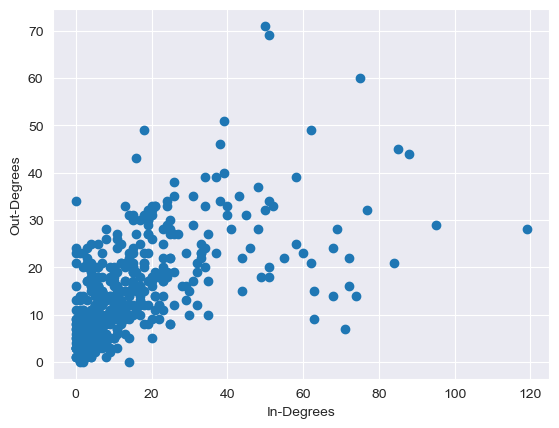

**Figure 1.1:** *The relationship between in- and out-degrees of all nodes.

In [4]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

#Extract the in-degree and out-degree values
x_values = rock_artists_graph_attributes["in_degrees"]
y_values = rock_artists_graph_attributes["out_degrees"]

# we created a scatter plot to visualize the relationship between in-degree and out-degree for all nodes.
plt.scatter(x_values, y_values)
plt.xlabel("In-Degrees")
plt.ylabel("Out-Degrees")
plt.show()
display(Markdown("**Figure 1.1:** *The relationship between in- and out-degrees of all nodes."))

As Figure xx. shows, most artists have both few incoming and outgoing links, clustered near the origin.
A small number of nodes have extremely high out-degree or high in-degree,
suggesting a highly heterogeneous, hub-dominated structure.

In [5]:
in_deg = dict(rock_artists_graph.in_degree())
out_deg = dict(rock_artists_graph.out_degree())

In [6]:
from scipy import stats
import numpy as np
#the original network
#average in degree
total_in_degree = sum(in_deg.values())
avg_in_degree = total_in_degree / rock_artists_graph.number_of_nodes()
print(f"The average in-degree is: ", avg_in_degree)

#median in degree
median_in_degree = np.median(list(in_deg.values()))
print(f"The median indegree is: ", median_in_degree)

#mode in degree
mode_in_degree = stats.mode(list(in_deg.values()), keepdims=False).mode
print(f"The mode indegree is: ", mode_in_degree)

#minimum in degree
min_in_degree = min(in_deg.values())
print(f"The minimum in-degree is: ", min_in_degree)

#maximum  degree
maximum_in_degree = max(in_deg.values())
print(f"The maximum in-degree is: ", maximum_in_degree)

#minimum out degree
min_out_degree = min(out_deg.values())
print(f"The minimum out-degree is: ", min_out_degree)

#maximum out degree
maximum_out_degree = max(out_deg.values())
print(f"The maximum out-degree is: ", maximum_out_degree)

The average in-degree is:  14.973140495867769
The median indegree is:  10.0
The mode indegree is:  3
The minimum in-degree is:  0
The maximum in-degree is:  119
The minimum out-degree is:  0
The maximum out-degree is:  71


The average in-degree is 15.5, the median is 10, and the mode is 4. They are much lower, showing that most artists receive only few incoming links while a small number act as major hubs. The maximum in-degree of 120 and maximum out-degree of 182 highlight the strong asymmetry and heterogeneity in connectivity. This is typical of scale-independent, node-dominated networks.

In [7]:
# Degree centrality
deg_cent = nx.degree_centrality(rock_artists_graph)
print(sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5])

# Betweenness centrality
bet_cent = nx.betweenness_centrality(rock_artists_graph)
print(sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:5])

# Eigenvector centrality (directed)
eig_cent_in = nx.eigenvector_centrality(rock_artists_graph, max_iter=1000)
print(sorted(eig_cent_in.items(), key=lambda x: x[1], reverse=True)[:5])


[('Led Zeppelin', 0.30434782608695654), ('Black Sabbath', 0.27950310559006214), ('Queen (band)', 0.2732919254658385), ('Metallica', 0.26915113871635615), ('Bob Dylan', 0.2567287784679089)]
[('Deep Purple', 0.04328761792645038), ('Queen (band)', 0.03973736999660883), ('Alice in Chains', 0.036860106969053424), ("Guns N' Roses", 0.03630642173933055), ('Jimi Hendrix', 0.03398917778239813)]
[('Led Zeppelin', 0.2311608378471955), ('Black Sabbath', 0.19389740387918397), ('Queen (band)', 0.18215207768672), ('Metallica', 0.18091295084493206), ('David Bowie', 0.15963732159110777)]


Note that here we need to have powerlaw 1.5 version in order this to work!

In [8]:
import powerlaw
in_degree_values = list(in_deg.values())
# We removed a few nodes with zero in-degree, since log-based power-law fitting can't handle zero values
in_degree_values = [val for val in in_degree_values if val >0]
in_degree_results = powerlaw.Fit(in_degree_values, discrete=True)
print (f"In-degree results: ", in_degree_results.power_law.alpha)

in_degree_xmin_value = in_degree_results.power_law.xmin
print (f"Minimum in-degree value: ", in_degree_xmin_value)

# Compute the KS statistic, which quantifies how well the data fits the theoretical power-law model.
in_degree_KS_value = in_degree_results.power_law.KS()
print (f"In-degree KS value: ", in_degree_KS_value)


out_degree_values = list(out_deg.values())
# Convert to list and remove zero-degree nodes for the same reason as above
out_degree_values = [val for val in out_degree_values if val >0 ]
out_degree_results = powerlaw.Fit(out_degree_values, discrete=True)
print (f"Out-degree results: ", out_degree_results.power_law.alpha)

#total degree distribution
total_deg = dict(rock_artists_graph.degree())
total_degree_values = list(total_deg.values())
total_degree_values = [val for val in total_degree_values if val > 0]  # Remove zero values
total_degree_results = powerlaw.Fit(total_degree_values, discrete=True)
print (f"Total degree results: ", total_degree_results.power_law.alpha)


Calculating best minimal value for power law fit
In-degree results:  2.5503435525115723
Minimum in-degree value:  15.0
In-degree KS value:  0.06583520426320338
Calculating best minimal value for power law fit
Out-degree results:  5.1194874525010485
Calculating best minimal value for power law fit
Total degree results:  5.6213013509179435


The power-law fitting shows that both the in- and out-degree distributions follow a long-tailed pattern.
This means that most artists have only a few links, while a small number of hubs have very many connections.

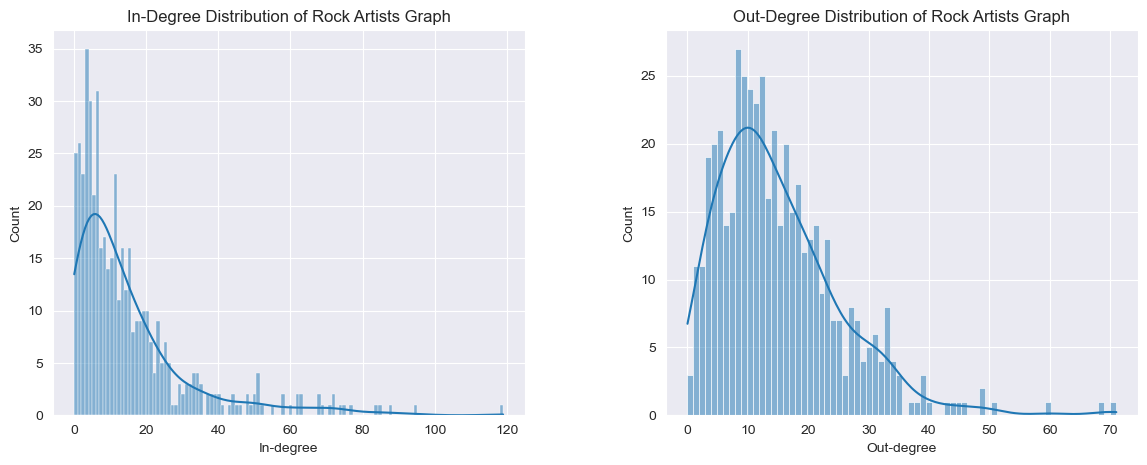

**Figure 1.2:** *In-Degree Distribution of Rock Artists Graph*

**Figure 1.3:** *Out-Degree Distribution of Rock Artists Graph*

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

in_deg = rock_artists_graph_attributes["in_degrees"]
out_deg = rock_artists_graph_attributes["out_degrees"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(in_deg, bins=max(in_deg) - min(in_deg) + 1, kde=True, ax=axes[0])
axes[0].set_title("In-Degree Distribution of Rock Artists Graph")
axes[0].set_xlabel("In-degree")
axes[0].set_ylabel("Count")


sns.histplot(out_deg, bins=max(out_deg) - min(out_deg) + 1, kde=True, ax=axes[1])
axes[1].set_title("Out-Degree Distribution of Rock Artists Graph")
axes[1].set_xlabel("Out-degree")
axes[1].set_ylabel("Count")

plt.subplots_adjust(wspace=0.3)
plt.show()

display(Markdown("**Figure 1.2:** *In-Degree Distribution of Rock Artists Graph*"))
display(Markdown("**Figure 1.3:** *Out-Degree Distribution of Rock Artists Graph*"))


#### General conclusion based on the above analysis

The directed rock artist network has 485 nodes and 7,507 edges, where each node represents a rock band and each edge shows a hyperlink between their Wikipedia pages.
When we looked at the largest undirected connected component (GCC), it included all 485 nodes and 6,215 edges, with a density of 0.53, meaning most of the main network is well connected.
However, the overall network is still sparse, with a density of only 0.03. The average degree of about 31 shows that most artists are connected to a few others, while some highly connected hubs dominate the structure.

A few nodes have very high in- or out-degrees, which makes the network uneven.
The average in-degree is 15.5, the median is 10, and the mode is 4, which means most artists receive only a few incoming links, as shown in Figure xx, forming a dense cluster near the origin. The maximum in-degree (120) and maximum out-degree (182) also show how unequal the network is.

Finally, the power-law fitting shows a long-tailed pattern for both in- and out-degrees. This means most artists have only a few links, but a small number of hubs have very many, which is typical for scale-free networks where a few key nodes hold the system together.

### Giant connected component

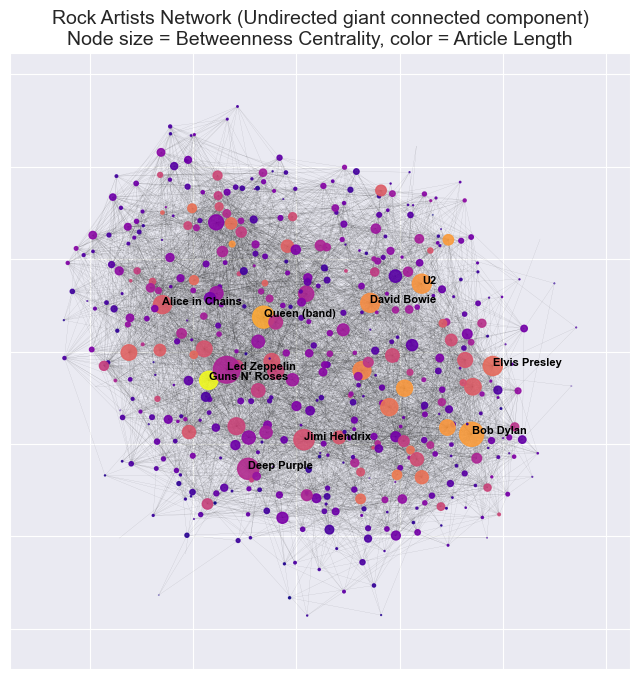

**Figure 1.4:** *Rock Artists Network (Undirected giant connected component)*

In [10]:
#For some analysis we use the GGC, because it shows the main connected part of the network where most nodes are linked,
# making the results more accurate and easier to interpret.

largest_cc_nodes = max(nx.connected_components(rock_artists_graph_undirected), key=len)
giant_connected_component = rock_artists_graph_undirected.subgraph(largest_cc_nodes).copy()

#We computed betweenness centrality on the GCC, because smaller parts or isolated nodes would give meaningless or unstable values.
betweenness_centrality = nx.betweenness_centrality(giant_connected_component)
node_size_bc = [betweenness_centrality[node] * 8000 for node in giant_connected_component.nodes()]
node_colors = []
for node in rock_artists_graph.nodes():
    grad_word_count = rock_artists_graph.nodes[node]['word_count']
    node_colors.append(grad_word_count)

# Compute 2D layout with ForceAtlas2, because the Week 5 exercise specifically asked to use this layout for visualization.
pos = nx.forceatlas2_layout(giant_connected_component, gravity=10)

plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(
    giant_connected_component, pos,
    node_size=node_size_bc,
    node_color=node_colors,
    cmap="plasma",
    alpha=0.9
)
nx.draw_networkx_edges(giant_connected_component, pos, width=0.1, alpha=0.3)

# Showing all node labels would make the plot unreadable, so we only display the labels of the 10 most central nodes.
top_labels = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, bc in top_labels:
    plt.text(
        pos[node][0],
        pos[node][1],
        node,
        fontsize=8,
        fontweight="bold",
        color="black"
    )

plt.title("Rock Artists Network (Undirected giant connected component)\nNode size = Betweenness Centrality, color = Article Length", fontsize=14)

plt.show()
display(Markdown("**Figure 1.4:** *Rock Artists Network (Undirected giant connected component)*"))


### Backbone analysis and visualization

In [11]:
#We create a weighted undirected graph based on the betweenness centrality
weighted_rock_artist_graph1 = rock_artists_graph.to_undirected(reciprocal=False, as_view=True)

We chose Weighted Network 1 because it uses edge betweenness centrality to set the weights.
This means that edges that connect important parts of the network get higher values.
It helps to keep the most meaningful connections and makes the main structure of the Rock Artists network clearer.

In [12]:
#We calculated the assortavity coefficient of the weighted network
#This measures whether the nodes tend to connect to others with similar degree values
assortative_coefficient_w1 = nx.degree_assortativity_coefficient(weighted_rock_artist_graph1)
print("The assortative coefficient of the weighted rock artists graph based on betweenness centrality is: ", assortative_coefficient_w1)

The assortative coefficient of the weighted rock artists graph based on betweenness centrality is:  0.0033467758033124497


The assortavity coefficient shows, that the nodes connect to other nodes with different properies.

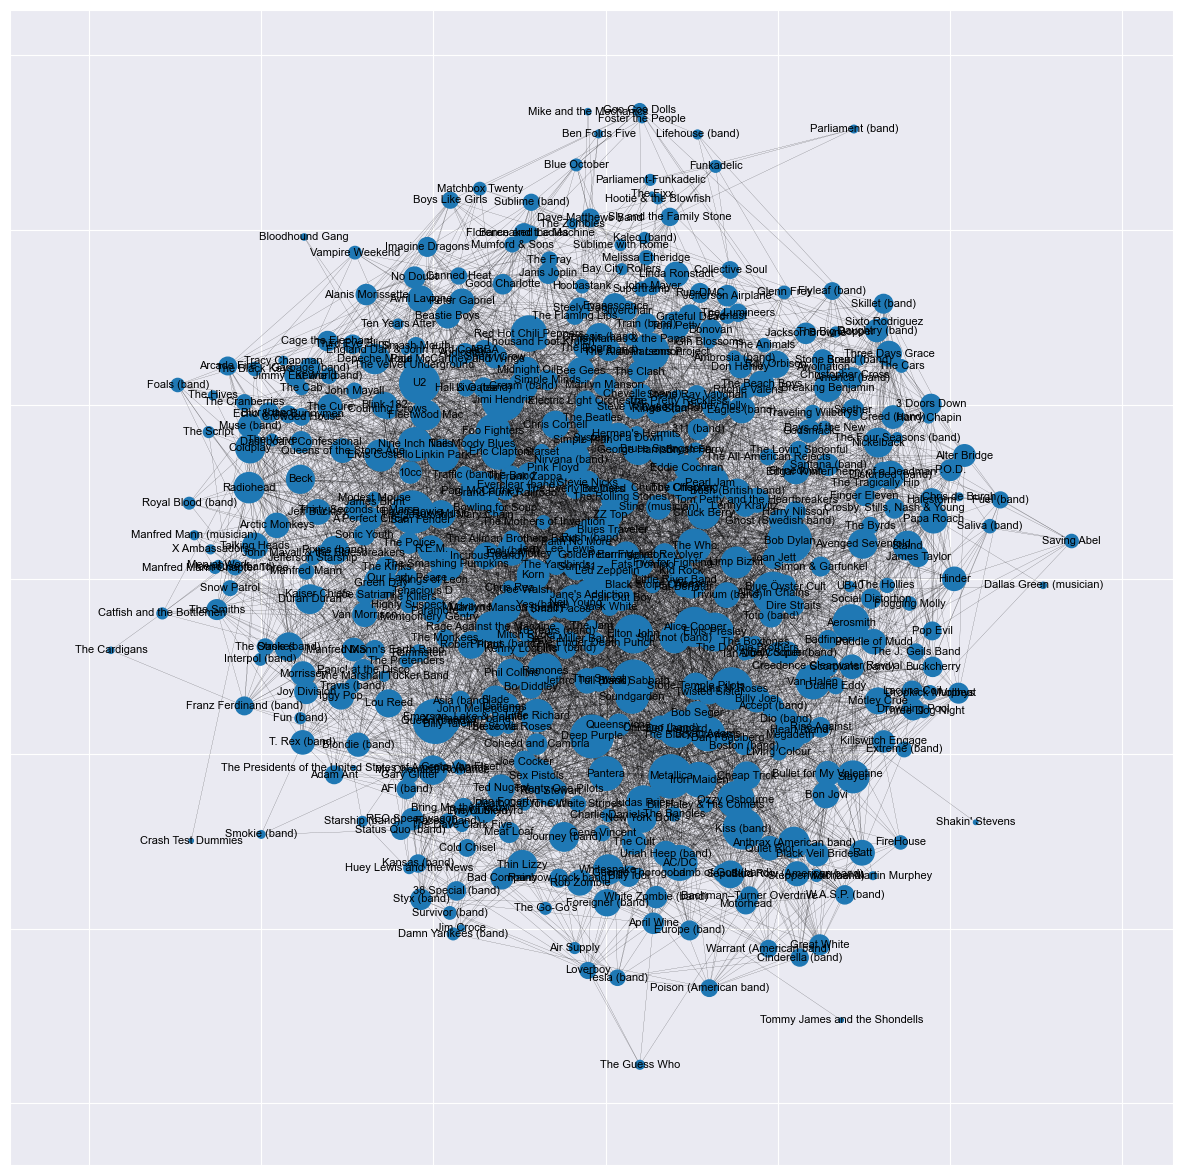

**Figure 1.5:** *Plot of the weighted rock artist graph based on the betweenness centrality*

In [13]:
#plotting the network using forceatlas2 layout, the size according to the total degree.

#We calculated the node size based on total degree and multiplied by 10 simply scales the sizes to make them visually distinguishable on the plot.
node_size_total_degree = [weighted_rock_artist_graph1.degree(node) * 10 for node in weighted_rock_artist_graph1.nodes()]

# We computed the node positions using the ForceAtlas2 layout algorithm.
# This layout spreads the nodes based on their connections, by that means, similar nodes are placed closer together.
# The "gravity" parameter helps by pulling nodes toward the center, that keeps the layout compact
pos = nx.forceatlas2_layout(weighted_rock_artist_graph1, gravity = 10)
plt.figure(1, figsize=(15,15))
nx.draw_networkx(weighted_rock_artist_graph1, pos, width=0.1, node_size = node_size_total_degree, font_size= 8)
plt.show()
display(Markdown("**Figure 1.5:** *Plot of the weighted rock artist graph based on the betweenness centrality*"))

In [14]:
#We calculate the betweenness centrality for each node. It shows how often a node appears on the shortest paths between other nodes in the network.
betweenness_centrality_w1 = nx.betweenness_centrality(weighted_rock_artist_graph1)

#we find the maximum and minimum betweenness centrality values, so later we can normalize the values between 1 and 100
max_bc1 = max(betweenness_centrality_w1.values())
min_bc1 = min(betweenness_centrality_w1.values())

#We loop through each egdge from u to v. u is the source node and v is the target node
for u, v in weighted_rock_artist_graph1.edges():
    #the source_bc variable shows how important the connetion is
    source_bc1 = betweenness_centrality_w1[u]

    if max_bc1 == min_bc1:
        weight = 1.0
    else:
        #We normalize the weight between 1 and 100
        weight = 1 + (source_bc1 - min_bc1) / (max_bc1 - min_bc1)*99
    #We assign the weight to the edge
    weighted_rock_artist_graph1[u][v]['weight'] = weight

In [15]:
# 3 column of the table: src, trg, weight
# We prepared a table because the disparity_filter function requires the input data to be in a tabular format.
# This table was then saved as a CSV file and loaded using the read function from the backboning library.
# we use tab as separator as it is required in the read me

import pandas as pd

#Create an empty list to store edge information for creating a DataFrame
edge_data = []
with open("weighted_network1.txt", "w", encoding="utf-8") as f:
    f.write("src\ttrg\tweight\n")
    for u, v , data in weighted_rock_artist_graph1.edges(data=True):
        weight = data.get('weight', 1.0)
        f.write(f"{u}\t{v}\t{data['weight']}\n")
        edge_data.append({"src": u, "trg": v, "nij": weight})

# Convert the list of edge dictionaries into a pandas DataFrame.
df = pd.DataFrame(edge_data)
# Save the DataFrame as a tab-separated CSV file
# We use the \t as the separator is important, because the backboning library’s README specifies that the input must be tab-delimited.
df.to_csv("weighted_rock_artists_graph_bc.csv", sep="\t", index=False)


In [16]:
import backboning as bn
# The "read" function loads the data in the correct format expected by the library.
df_edges, _, _ = bn.read("./weighted_rock_artists_graph_bc.csv", "nij")

# We used the disparity filter because it was recommended in the Week 5 exercise as the method for extracting the network backbone.
# This filter removes statistically insignificant edges while keeping the most relevant connections based on their local weight distribution.
backbone_w1 = bn.disparity_filter(df_edges)

import pandas as pd
import networkx as nx
from backboning import disparity_filter

# Ensure the weight column is named correctly ('nij'), as required by the disparity_filter function.
df_edges = df_edges.rename(columns={'weight': 'nij'})

backbone_df = disparity_filter(df_edges)

# Filter the resulting backbone by significance score
# Only keep edges with a score above 0.62 to retain the strongest connections
# The 0.62 threshold was chosen to retain only the most significant edges in the disparity filter,
# removing weak/noisy links while preserving the main structure of the network for analysis.
backbone_df = backbone_df[backbone_df['score'] > 0.62]


Calculating DF score...
Calculating DF score...


Using the Disparity Filter method (as introduced in the lecture), we extracted the backbone of the weighted Rock Artists network. The algorithm assigns a significance score to each edge and retains only the statistically relevant ones. The original network contained 6,215 edges, and after applying a significance threshold of alpha = 0.62, approximately 69% of the edges remained (4,313 edges), highlighting the most meaningful and structurally important connections within the network.

In [17]:
# Convert the filtered backbone DataFrame back into a NetworkX graph.
backbone_w1 = nx.from_pandas_edgelist(backbone_df, source="src", target="trg", edge_attr="score")

# Compare the size of the original network to the extracted backbone
# This represents, how much the network was reduced after filtering
print("Number of edges in the original graph:", weighted_rock_artist_graph1.number_of_edges())
print("Number of edges in the backbone:", backbone_w1.number_of_edges())

Number of edges in the original graph: 5981
Number of edges in the backbone: 4140


After we applied the Disparity Filter, we created a new backbone network using the significant edges only.
The resulting backbone contains fewer edges than the original graph, keeping only the most relevant connections that represent the core structure of the network.

In [18]:
#We compare the  the network and the backbone

#Density
original_density = nx.density(weighted_rock_artist_graph1)
backbone_density = nx. density(backbone_w1)
print(f"The density of the original network: {original_density}.\n and the density of the backbone: {backbone_density}")


#Compare average degree
original_avg_degree = sum(dict(weighted_rock_artist_graph1.degree()).values()) / weighted_rock_artist_graph1.number_of_nodes()
backbone_deg = sum(dict(backbone_w1.degree()).values()) / backbone_w1.number_of_nodes()

print(f"The average degree before: {original_avg_degree}\n The average degree after: {backbone_deg}")
#Calculate the percentage of edges removed during backbone extraction.
print(f"The edges reduced by: {(1 - backbone_w1.number_of_edges() / weighted_rock_artist_graph1.number_of_edges()):.2%}")

The density of the original network: 0.051169515596393066.
 and the density of the backbone: 0.038876524776741694
The average degree before: 24.714876033057852
 The average degree after: 17.92207792207792
The edges reduced by: 30.78%


After applying the Disparity Filter, the network became a bit sparser. The density dropped from 0.053 to 0.040, and the average degree decreased from 25.6 to 18.6. This means the backbone kept the most important connections and removed the weaker ones.

In [19]:
# We compared the number of nodes and edges between the original weighted network and its backbone
# This shows how much the network was simplified after applying the disparity filter
original_nodes = weighted_rock_artist_graph1.number_of_nodes()
original_edges = weighted_rock_artist_graph1.number_of_edges()

backbone_nodes = backbone_w1.number_of_nodes()
backbone_edges = backbone_w1.number_of_edges()

print(f"The original network's number of edges: {original_edges}, and nodes: {original_nodes}\n the Backbone's number of edges: {backbone_edges}, and nodes: {backbone_nodes}")

n_components_original = nx.number_connected_components(weighted_rock_artist_graph1)
n_components_backbone = nx.number_connected_components(backbone_w1)


print(f"The connectec components {n_components_original}")


The original network's number of edges: 5981, and nodes: 484
 the Backbone's number of edges: 4140, and nodes: 462
The connectec components 1


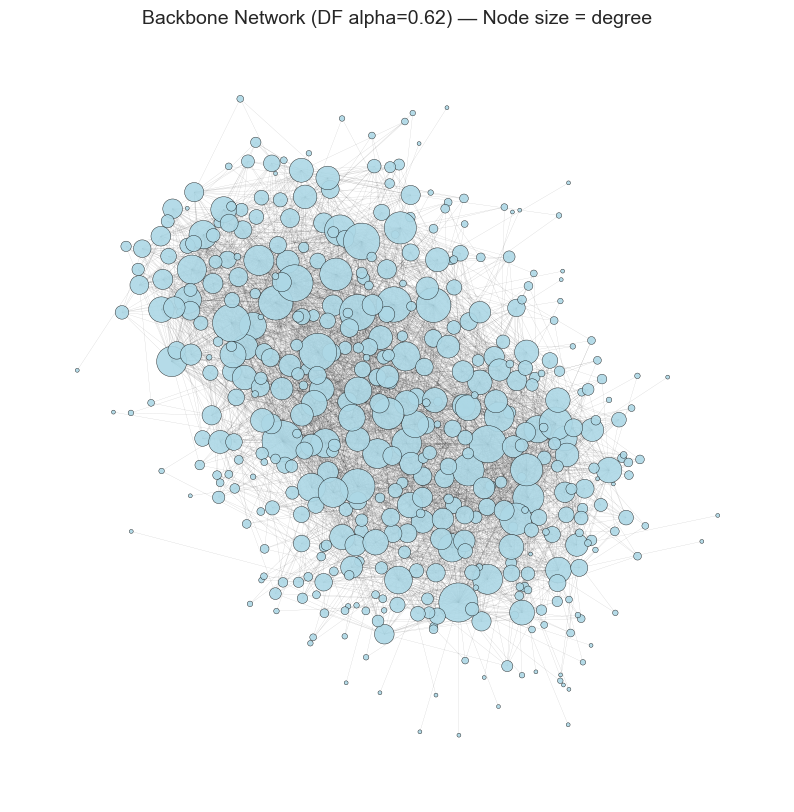

**Figure 1.6:** *Backbone network visualization*

In [20]:
# Assignment-compliant backbone plot (no color, size = total degree)
bb_nodes = max(nx.connected_components(backbone_w1), key=len)
BB = backbone_w1.subgraph(bb_nodes).copy()

node_size_deg_bb = [BB.degree(n) * 8 for n in BB.nodes()]
pos_bb = nx.forceatlas2_layout(BB, gravity=10)

plt.figure(figsize=(10,10))
nx.draw_networkx_edges(BB, pos_bb, width=0.15, alpha=0.25, edge_color="black")
nx.draw_networkx_nodes(
    BB, pos_bb,
    node_size=node_size_deg_bb,
    node_color="lightblue",
    edgecolors="black",
    linewidths=0.3,
    alpha=0.9
)
plt.title("Backbone Network (DF alpha=0.62) — Node size = degree", fontsize=14)
plt.axis('off')
plt.show()
display(Markdown("**Figure 1.6:** *Backbone network visualization*"))


In [21]:
bc_back = nx.betweenness_centrality(backbone_w1)

#We print out only the first 5 results, to avoid printing out a long list
for node, value in list(bc_back.items())[:5]:
    print(f"{node}: {value}")

10cc: 0.0025890790983193685
Ramones: 0.010730471865637444
Eric Clapton: 0.01785504774767681
Duran Duran: 0.01044248997688332
The Yardbirds: 0.0002565525281400561


This code measures how much each node (artist) acts as a bridge between others in the network, then displays the first 5 results to illustrate the concept without printing the full dataset.

In [22]:
clust_orig = nx.average_clustering(weighted_rock_artist_graph1.to_undirected())
clust_back = nx.average_clustering(backbone_w1)
print(f"Clustering before: {clust_orig:.3f}, after: {clust_back:.3f}")


Clustering before: 0.234, after: 0.289


The average clustering increased from 0.234 to 0.293 after we applied the disparity filter.
This means that the backbone network became weaker, random links were removed, while strong, meaningful connections within communities were preserved.
As a result, the remaining nodes form tighter clusters, highlighting the core community structure of the rock artist network.

In [23]:
assort_back = nx.degree_assortativity_coefficient(backbone_w1)
print(f"Degree assortativity of the backbone: {assort_back:.3f}")


Degree assortativity of the backbone: -0.186


The assortativity value of -0.160 means the backbone network is disassortative. Popular or well-connected nodes tend to link with smaller, less connected ones instead of other big hubs.

In [24]:
deg_values = []
for node, degree in backbone_w1.degree():
    if degree > 0:
        deg_values.append(degree)

fit_backbone = powerlaw.Fit(deg_values, discrete=True)
print(f"Alpha (backbone): {fit_backbone.power_law.alpha:.2f}, xmin: {fit_backbone.power_law.xmin}")

fit_backbone = powerlaw.Fit(deg_values, discrete=True)
print(f"Alpha (backbone): {fit_backbone.power_law.alpha:.2f}, xmin: {fit_backbone.power_law.xmin}")


Calculating best minimal value for power law fit
Alpha (backbone): 3.41, xmin: 33.0
Calculating best minimal value for power law fit
Alpha (backbone): 3.41, xmin: 33.0


For nodes with a degree above 34, the degree distribution roughly follows a power-law pattern, but with a relatively steep slope (since alpha > 3).
A higher α value indicates that very high-degree nodes are rare, so the network is less dominated by superhubs compared to a classic scale-free network.

#### Backbone analysis

The network was processed using the Disparity Filter, to extract the backbone, to highlight the most significant relationships, while it reduced the its noise from weaker connections. The original network consisted 485 nodes and 6215 edges, with a density of 0.0512. After the backbone extraction, the network reduced to 463 nodes and 4313 edges, resulting a lower density of 0.0403. Approximately 28% of the edges were removed. It indicated that the less significant links were filtered, and the backbone retains only the most meaningful connections.
Comparted tot he original network, the backbone’s average degree decreased from 24.71 to 18.63, that reflects that only the main central of the network remained.
Ont he other hand, the average clustering coefficient increased from 0.234 to 0.293 after the extraction. This means, that the backbone preserved tight-knit communities, with more densely interconnected nodes, even as the overall network became sparser.
Moreover, the process didn’t fragment the network, the backbone remained a fully-connected component.
The degree distribution follows a power-law pattern (alpha = 3.37, xmin = 34), indicating that a small number of nodes are highly connected, while most nodes maintain only a few links.


I used the code from the previous assignment to download Wikipedia pages of rock artists. I created a file named `download_wikipedia_json.py` with the code below:

# Part 2: Genres and communities and plotting
## Our response regarding genres and modularity:
The original network consisted of 484 nodes, of which 482 were successfully assigned genre information. By taking the first genre listed for every artist, we found that there are around 89 different categories. In comparison if we took a random genre from their list we found arount 200 genre categories. This is due to the fact that there are a lot of rock genres.

We made communities based on the artists' first genre. We also made communities where for every artist we took a random genre.

After that we calculated the modularity by forming communities based on their node's genre. By taking the artists' first genre, the modularity of the communities was 0.051953154839864436, more than 10 times bigger than taking a random genre from their genre list (there the modularity is: 0.0080). This is likely to be due to the fact that the first genre in the artits listing is there most prominent one, and they are more likely to be connected to other artists who have the same genre as the first in their listing.

By the modularity, we observe that taking the first genre of the artist can form some communities, but it is not optimal, given that the modularity is not that high and with the louvain-algorithm we found communities with higher modularity.


In [25]:
from download_wikipedia_json import download_pages

favorite_pages = [
    "List of mainstream rock performers"
]

download_pages(favorite_pages)


--- Processing: List of mainstream rock performers ---
Downloading: List of mainstream rock performers
Saved: wikipedia_pages/List of mainstream rock performers.json
Successfully downloaded and saved: wikipedia_pages/List of mainstream rock performers.json
Extracted 492 artists and saved to artists.txt
Downloading: 10 Years (band)
Saved: wikipedia_pages/10 Years band.json
Downloading: 10cc
Saved: wikipedia_pages/10cc.json
Downloading: 3 Doors Down
Saved: wikipedia_pages/3 Doors Down.json
Downloading: 311 (band)
Saved: wikipedia_pages/311 band.json
Downloading: 38 Special (band)
Saved: wikipedia_pages/38 Special band.json
Downloading: A Perfect Circle
Saved: wikipedia_pages/A Perfect Circle.json
Downloading: ABBA
Saved: wikipedia_pages/ABBA.json
Downloading: AC/DC
Saved: wikipedia_pages/ACDC.json
Downloading: AFI (band)
Saved: wikipedia_pages/AFI band.json
Downloading: Accept (band)
Saved: wikipedia_pages/Accept band.json
Downloading: Adam Ant
Saved: wikipedia_pages/Adam Ant.json
Downl

## Detect the communities, discuss the value of modularity in comparison to the genres.

As Week7 Part2 stated I used LLM to generate the code for extracting genres from the Wikipedia JSON files. I added most of the codes into get_artist_genres.py.
For this I used claude-2. The prompt I used was the following:
I have a lot of rock artist's wikipedia page downloaded in json. On the wikipedia page, there is an infobox on the side which contains the genre that artist is in in this format: genre             = {{hlist|[[Art rock]]. Make a python code into jupyter notebook which take those and for each artist save that into a list.

It generated a code, but it could not extract the genres from the json so I uploaded a json for example. After that it managed to generate a code that could extract the genres from the json files. I then used this code to extract the genres from all the json files I had downloaded. I also checked manually that the genres extracted were correct.

In [26]:
import json
from get_artist_genres import process_all_json_files, process_json_file
# Cell 6 - Markdown
## Usage Example

# Cell 7 - Code
# Set your directory path here
json_directory = "wikipedia_pages"  # Update this path

# Process all files
artist_genres = process_all_json_files(json_directory)

# Display results
print(f"\n{'='*60}")
print(f"Processed {len(artist_genres)} artists")
print(f"{'='*60}\n")

for item in artist_genres:
    print(f"Artist: {item['artist']}")
    print(f"Genres: {', '.join(item['genres']) if item['genres'] else 'No genres found'}")
    print("-" * 60)

# Cell 8 - Code
# Optional: Convert to a more structured format
import pandas as pd

# Create a DataFrame
df = pd.DataFrame(artist_genres)
df['genre_count'] = df['genres'].apply(len)
df['genres_string'] = df['genres'].apply(lambda x: ', '.join(x))

print(df[['artist', 'genre_count', 'genres_string']])

# Cell 9 - Code
# Optional: Save results to a new JSON file
with open('artist_genres_output.json', 'w', encoding='utf-8') as f:
    json.dump(artist_genres, f, indent=2, ensure_ascii=False)

print("Results saved to artist_genres_output.json")

# Cell 10 - Markdown
## Test with a Single File


# Cell 11 - Code
# Test with a single file
test_file = "path/to/your/test_file.json"  # Update this

result = process_json_file(test_file)
if result:
    print(f"Artist: {result['artist']}")
    print(f"Genres: {result['genres']}")

Found 493 JSON files
Processed: Fuel (band) - 4 genres found
Processed: Trivium (band) - 4 genres found
Processed: Stone Temple Pilots - 5 genres found
Processed: Thirty Seconds to Mars - 5 genres found
Processed: FireHouse - 2 genres found
Processed: Black Veil Brides - 5 genres found
Processed: The Mothers of Invention - 18 genres found
Processed: Queen (band) - 2 genres found
Processed: Foster the People - 6 genres found
Processed: Goo Goo Dolls - 13 genres found
Processed: Lamb of God (band) - 4 genres found
Processed: Herman's Hermits - 9 genres found
Processed: Michael Martin Murphey - 9 genres found
Processed: Janis Joplin - 6 genres found
Processed: The Kinks - 28 genres found
Processed: Simple Minds - 17 genres found
Processed: Pixies (band) - 6 genres found
Processed: Jackson Browne - 5 genres found
Processed: Midnight Oil - 12 genres found
Processed: Kings of Leon - 6 genres found
Processed: Jack White - 17 genres found
Processed: Peter Gabriel - 18 genres found
Processed: N

After this we converted a list of dictionaries to a dictionary with artists as keys and genres as values, so we can easily access the genres of each artist.

In [27]:
artist_genres_dict = {item['artist']: item['genres'] for item in artist_genres}

First we filtered the rock artists graph to only include nodes that have genre information.

In [28]:
import numpy as np
import networkx as nx

nodes_with_genres = set()
for artist in artist_genres_dict:
    if rock_artists_graph.has_node(artist) and artist_genres_dict[artist]:
        nodes_with_genres.add(artist)

print(f"Total nodes in original graph: {rock_artists_graph.number_of_nodes()}")
print(f"Nodes which have genre information: {len(nodes_with_genres)}")

rock_artists_graph_filtered = rock_artists_graph.subgraph(nodes_with_genres).copy()

Total nodes in original graph: 484
Nodes which have genre information: 482


Then we created a dictionary where the keys are genres and the values are sets of artists who has that genre being listed as their fist one. We also created a random genre dictionary, where the genre is randomly selected from the list of genres for each artist.

In [29]:
rock_artists_graph_communities_bygenre_dict = dict()
rock_artists_graph_communities_bygenre_dict_random= dict()
for artist in rock_artists_graph_filtered.nodes():
    genre = artist_genres_dict[artist][0]
    random_genre = artist_genres_dict[artist][np.random.randint(len(artist_genres_dict[artist]))-1]

    if genre not in rock_artists_graph_communities_bygenre_dict:
        rock_artists_graph_communities_bygenre_dict[genre] = set()
    if random_genre not in rock_artists_graph_communities_bygenre_dict_random:
        rock_artists_graph_communities_bygenre_dict_random[random_genre]  = set()

    rock_artists_graph_communities_bygenre_dict[genre].add(artist)
    rock_artists_graph_communities_bygenre_dict_random[random_genre].add(artist)
    rock_artists_graph_filtered.nodes[artist]['communities'] = genre

print(f"Number of genres if we take every artists' first genre from their list: {len(rock_artists_graph_communities_bygenre_dict)}")
print(f"Number of genres if we take a random genre from every artists' list: {len(rock_artists_graph_communities_bygenre_dict_random)}")

Number of genres if we take every artists' first genre from their list: 90
Number of genres if we take a random genre from every artists' list: 244


We can see that there are much more genres if we take a random genre from their list. This is due to the fact that there are plenty of rock genres. However, as the first genre in the listing is usually a common and prominent one for every artist.

After this we converted the dictionaries to lists of sets, where one set is one community. This is needed to calculate modularity using NetworkX. Then
we can calculate the modularity of the genre-based communities and compare it to the modularity of the random genre-based communities.

In [30]:
rock_artists_graph_communities_bygenre_list = list(rock_artists_graph_communities_bygenre_dict.values())
rock_artists_graph_communities_bygenre_list_random = list(rock_artists_graph_communities_bygenre_dict_random.values())

modularity_by_genre = nx.community.modularity(rock_artists_graph_filtered, rock_artists_graph_communities_bygenre_list)
modularity_by_genre_random = nx.community.modularity(rock_artists_graph_filtered, rock_artists_graph_communities_bygenre_list_random)
print(f"Modularity of communities formed by the artist's main genre: {modularity_by_genre}")
print(f"Modularity of communities formed by choosing a random genre of the artist: {modularity_by_genre_random}")

Modularity of communities formed by the artist's main genre: 0.051953154839864436
Modularity of communities formed by choosing a random genre of the artist: 0.008073183352813


008073183352813We can see that by taking the artists' first genre, the modularity of the communities was 0.051953154839864436, more than 10 times bigger than taking a random genre from their genre list (there the modularity is: 0.012010512444871715). This is likely to be due to the fact that the first genre in the artits listing is there most prominent one, and they are more likely to be connected to other artists who have the same genre as the first in their listing.

We think that taking the first genre of the artist can form some communities, but it is not the best optimal, given that the modularity is not that high and with the louvain-algorithm we found communities with higher modularity.

After this we used the Louvain-algorithm to detect communities and calculated the modularity of those communities.

In [31]:
louvain_modularity = nx.community.modularity(rock_artists_graph_filtered, nx.community.louvain_communities(rock_artists_graph_filtered))
print(f"Modularity with communities find by the Louvain-algorithm: {louvain_modularity}")

Modularity with communities find by the Louvain-algorithm: 0.29287373709069026


The modularity is higher with the communities found by the Louvain-algorithm. This means that the artists' genre is not a good predictor of community structure.

In [31]:
import matplotlib.pyplot as plt

# First, get the Louvain communities
louvain_communities = list(nx.community.louvain_communities(rock_artists_graph_filtered))

# Sort communities by size (largest first)
louvain_communities_sorted = sorted(louvain_communities, key=len, reverse=True)

# Create a dictionary mapping nodes to their community index
node_to_community = {}
for idx, community in enumerate(louvain_communities_sorted):
    for node in community:
        node_to_community[node] = idx

print(f"Found {len(louvain_communities_sorted)} communities")
print(f"Top 10 community sizes: {[len(c) for c in louvain_communities_sorted[:10]]}")



Found 5 communities
Top 10 community sizes: [172, 155, 85, 53, 17]


As the Louvain-algorithm is not dterministic, so each time we found 4-6 communities.

## Calculate the matrix $D$ and discuss your findings.

We made the D matrix in the following manner. The rows are the Louvain communities sorted by size (largest first) and the columns are the top 7 genres sorted by size (largest first). The values in the matrix are the number of artists in each Louvain community that belongs to each genre.

In [32]:
rock_artists_graph_communities_bygenre_list_sorted = sorted(rock_artists_graph_communities_bygenre_list, key=len, reverse=True)
top_7_genres = []
for community in rock_artists_graph_communities_bygenre_list_sorted[:7]:
    representative_node = next(iter(community))
    genre = rock_artists_graph_filtered.nodes[representative_node]['communities']
    top_7_genres.append(genre)

In [33]:
confusion_matrix = np.zeros((7, 7), dtype=int)

for community in louvain_communities_sorted:
    comm_idx = louvain_communities_sorted.index(community)
    if comm_idx < 7:
        for node in community:
            genre = rock_artists_graph_filtered.nodes[node]['communities']
            if genre in top_7_genres:
                genre_idx = top_7_genres.index(genre)
                confusion_matrix[comm_idx, genre_idx ] += 1

In [34]:
confusion_matrix

array([[45, 11,  4, 12,  0,  3, 13],
       [12, 13, 38,  2, 16,  4,  1],
       [ 7, 22,  1,  4,  0,  1,  0],
       [ 3, 11,  3,  1,  0,  3,  1],
       [ 4,  3,  2,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0]])

From the confusion matrix we can see that for there is usually a big overlap between the first two biggest genre and the first two biggest comunities found by the Louvain-algorithm. However, as there are 89 communities defined by the genres and we only visualize 7 here, not all the artists are in the confusion matrix.

## Plot the communities and comment on your results.


Here I plot the rock artists graph, coloring the nodes according to their Louvain community. The top 7 largest communities get distinct colors, while the rest are colored gray. However, there are only 4-6 communities, so every community have a different colour. We chose the 'tab10' colormap as we found that easy to distinguish.

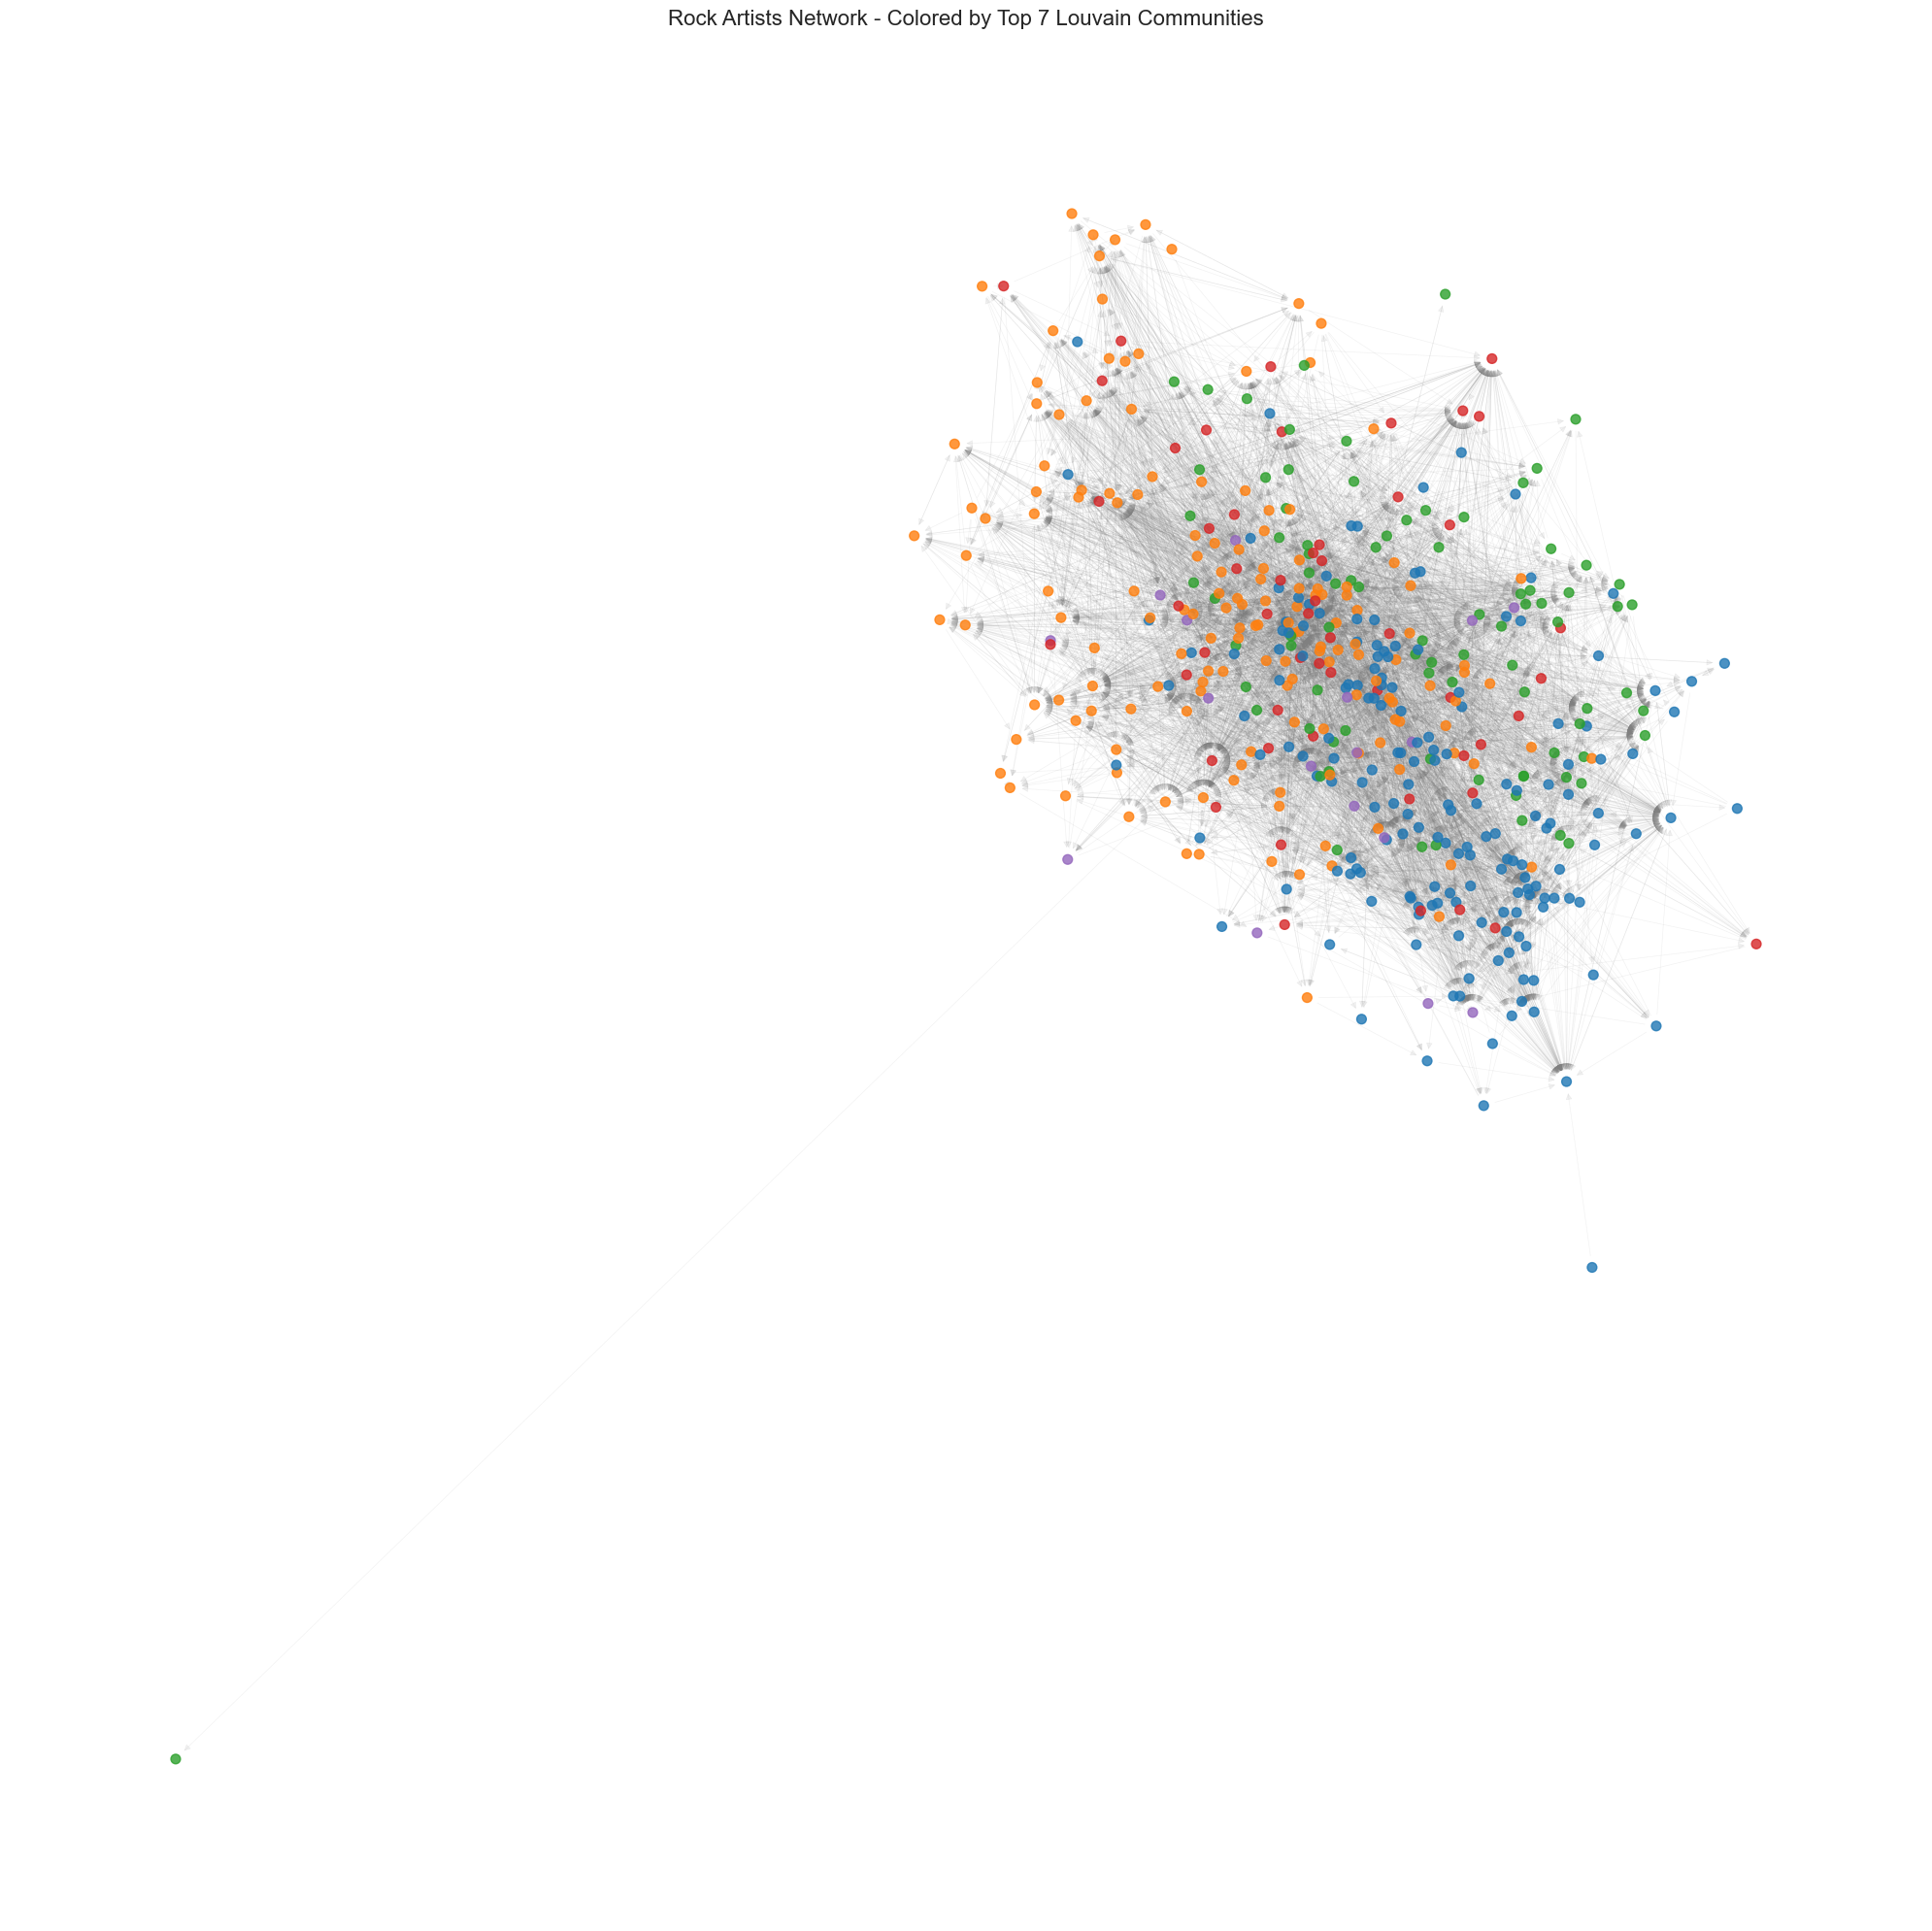

**Figure 2.1:** *Visualization of the graph by communities made by Louvain-algorithm. For the 7 biggest communities we assigned different colours and for the others we assigned gray. However, as Louvain-algorithm only produces 4-6 communities, all the communities get a colour.*

In [35]:
from IPython.display import display, Markdown
# Assign colors: top 7 communities get distinct colors, rest are gray
num_colored_communities = 7
colors = []
cmap = plt.colormaps.get_cmap('tab10')

for node in rock_artists_graph_filtered.nodes():
    comm_idx = node_to_community[node]
    if comm_idx < num_colored_communities:
        colors.append(cmap(comm_idx))
    else:
        colors.append('lightgray')
    pos = nx.forceatlas2_layout(rock_artists_graph_filtered, seed=42)


# Create visualization
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(rock_artists_graph_filtered, pos,
                       node_color=colors,
                       node_size=50,
                       alpha=0.8)
nx.draw_networkx_edges(rock_artists_graph_filtered, pos,
                       alpha=0.1,
                       width=0.5,
                       edge_color='gray')

plt.title(f"Rock Artists Network - Colored by Top {num_colored_communities} Louvain Communities",
          fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()
display(Markdown("**Figure 2.1:** *Visualization of the graph by communities made by Louvain-algorithm. For the 7 biggest communities we assigned different colours and for the others we assigned gray. However, as Louvain-algorithm only produces 4-6 communities, all the communities get a colour.*"))


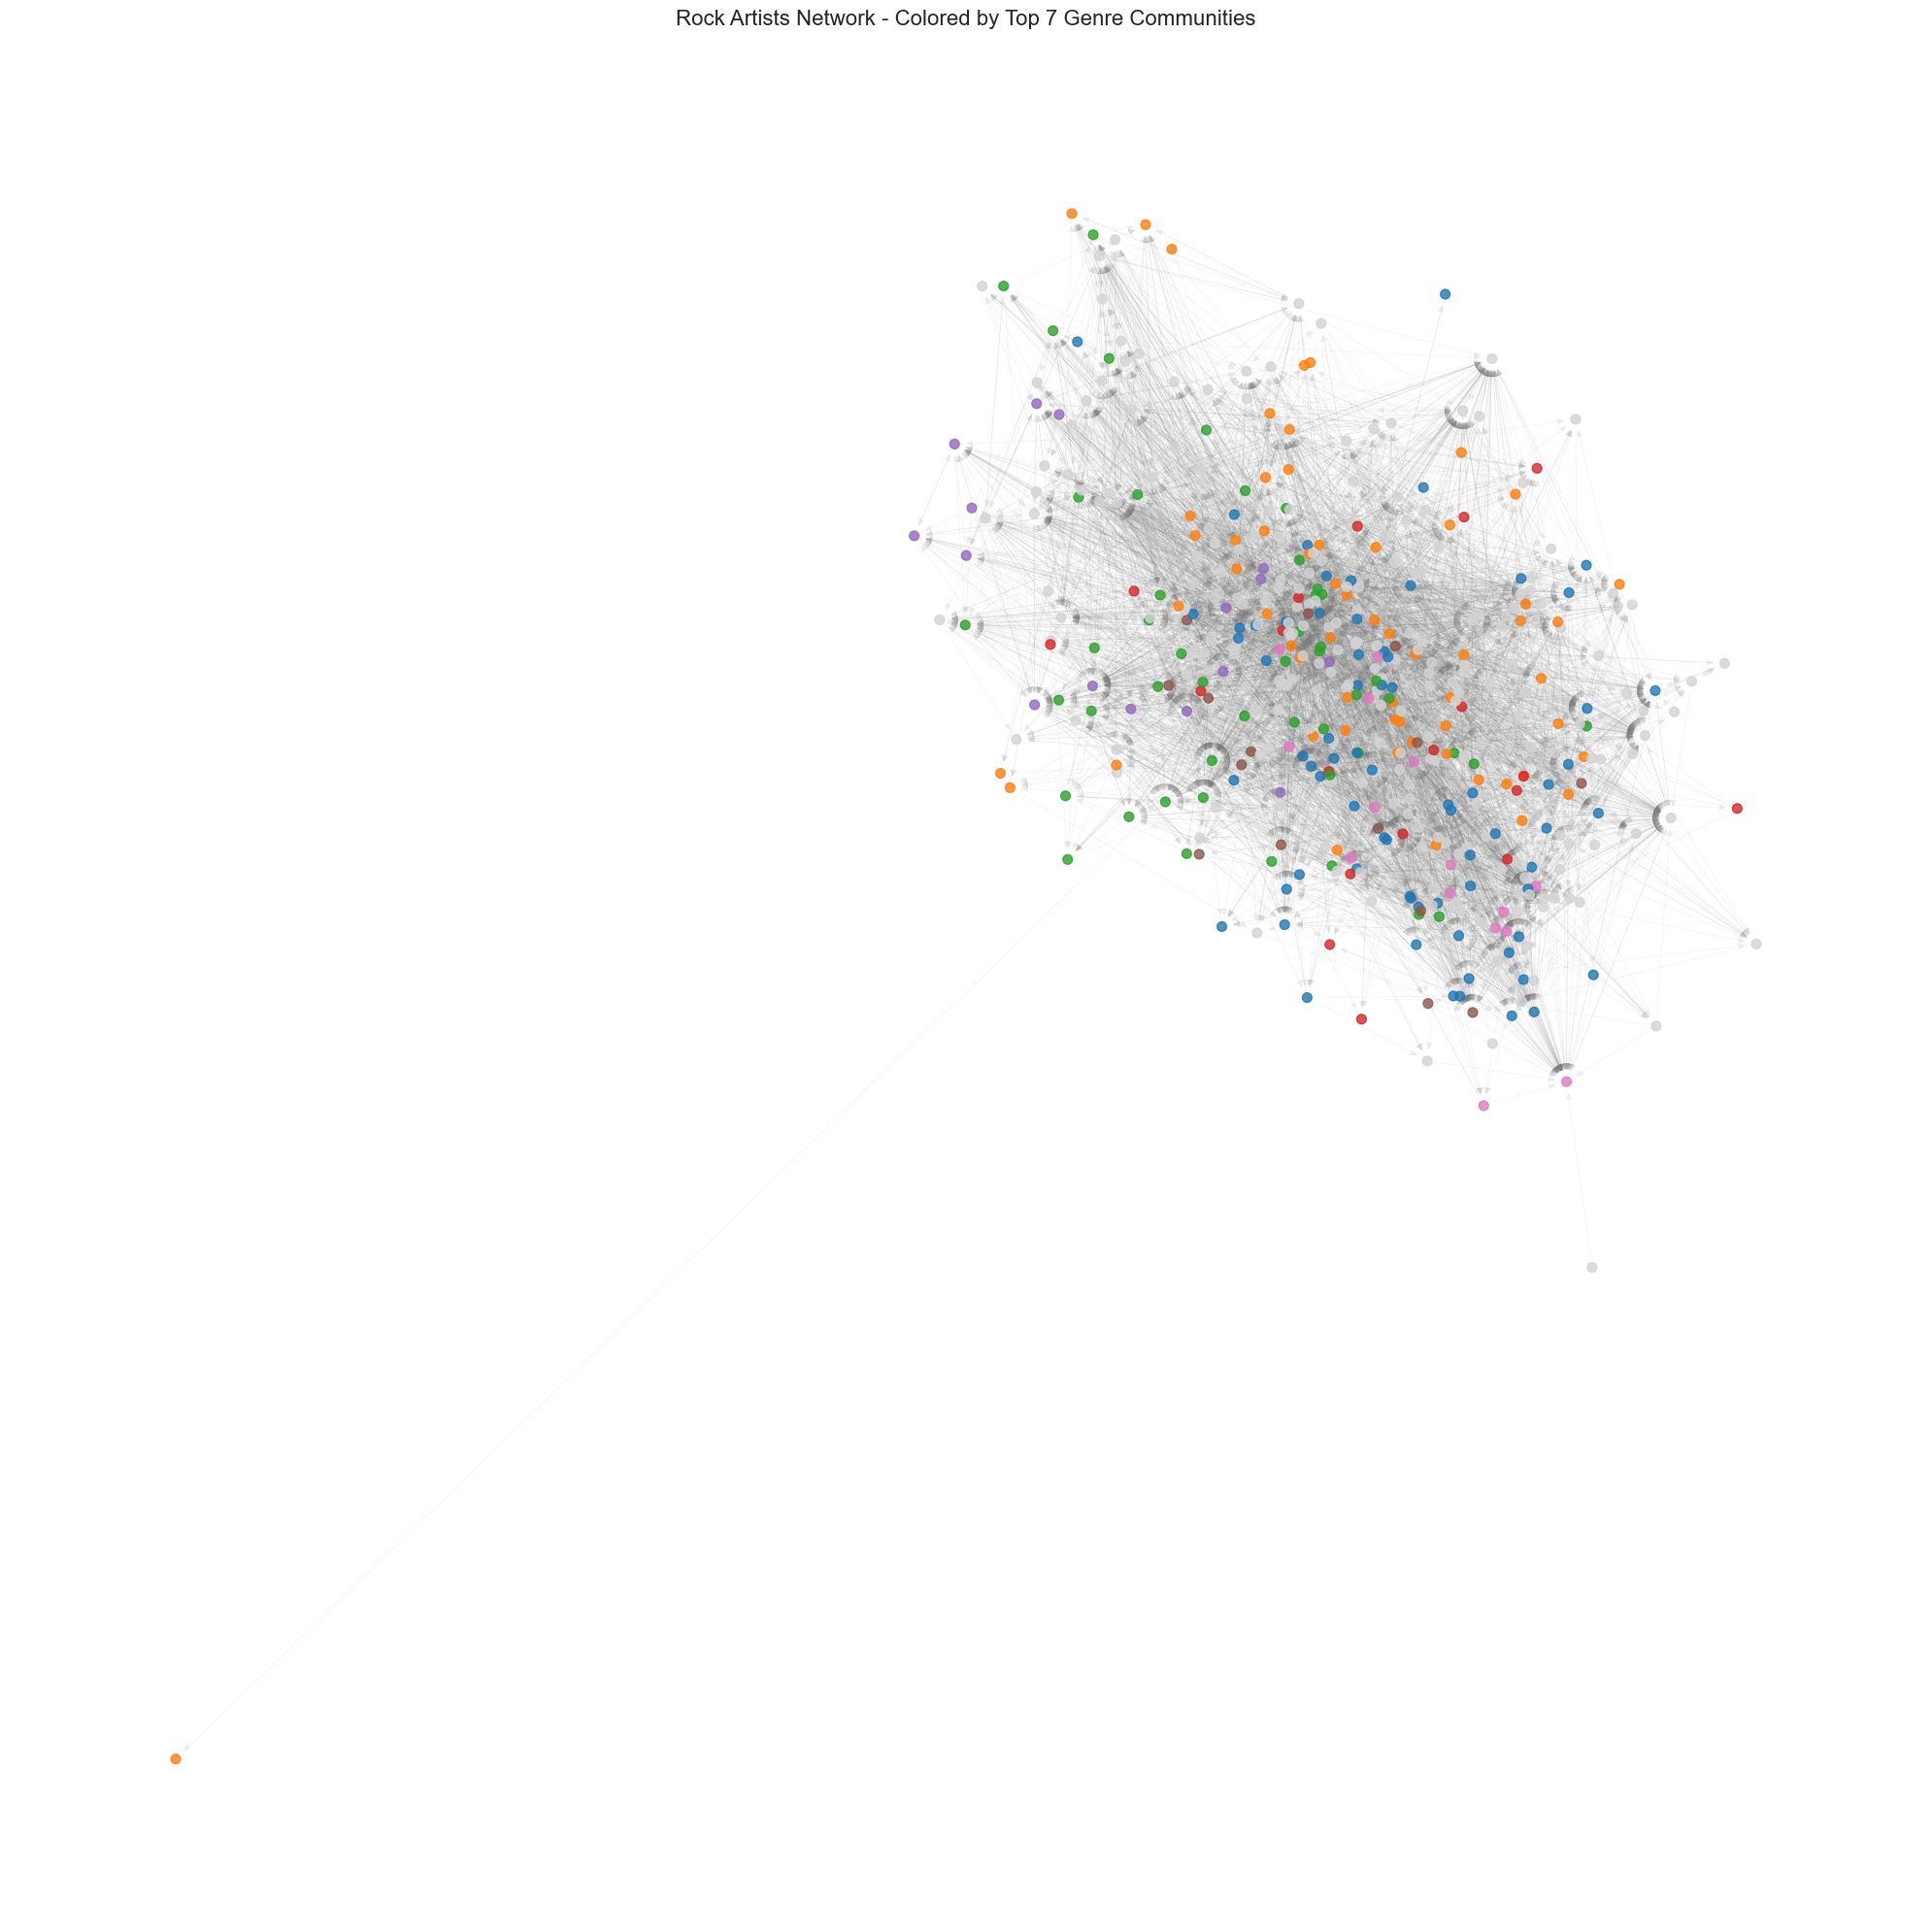

**Figure 2.2:** *Visualization of the graph by communities defined by the artists' first genre. For the 7 biggest communities we assigned different colours and for the others we assigned gray.*

In [36]:
# Create a dictionary mapping nodes to their community index

num_colored_communities = 7
colors = []
cmap = plt.colormaps.get_cmap('tab10')

node_to_community_genre = {}
for idx, community in enumerate(rock_artists_graph_communities_bygenre_list_sorted):
    for node in community:
        node_to_community_genre[node] = idx

for node in rock_artists_graph_filtered.nodes():
    comm_idx = node_to_community_genre[node]
    if comm_idx < num_colored_communities:
        colors.append(cmap(comm_idx))
    else:
        colors.append('lightgray')
    pos = nx.forceatlas2_layout(rock_artists_graph_filtered, seed=42)


# Create visualization
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(rock_artists_graph_filtered, pos,
                       node_color=colors,
                       node_size=50,
                       alpha=0.8)
nx.draw_networkx_edges(rock_artists_graph_filtered, pos,
                       alpha=0.1,
                       width=0.5,
                       edge_color='gray')

plt.title(f"Rock Artists Network - Colored by Top {num_colored_communities} Genre Communities",
          fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

display(Markdown("**Figure 2.2:** *Visualization of the graph by communities defined by the artists' first genre. For the 7 biggest communities we assigned different colours and for the others we assigned gray.*"))


From these visualizations we can observe a little bit more cluster separation on the communities formed by the Louvain-algorithm. However, these are not significant enough just by looking at the visualizations.

# Part 3: TF-IDF to understand genres and communities

## Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

In tf-idf we try to get the main words which describe the document accurately. For this, intuition would say that counting the most frequent words would be a good solution. However, only by counting the most frequent words would result in a list of words which are stopwords, articles, etc. (such as a, the, and, etc.). To counter this we use idf, which measures how unique or rare a word is across all documents. This way, tf-idf achieves the highlighting of a word if it is frequent in one document and rare in others. With this common words which are in every document.

Tf-idf can help us see which words can best describe artists who have the same genre. We can also see if there is an underlying similarity between artists text who got put into the same community by the Louvain-algorithm, or perhaps it is a different thing which make them have an edge with each other in our graph (by being referenced by).

## Calculate and visualize TF-IDF for the genres and communities.

We had to download the nltk packages.

In [37]:
import nltk

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dhanna/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dhanna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/dhanna/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/dhanna/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

We created a communities_tfidf dictionary which have two TFIDF_Communities. One of the made by the communities defined by artists' genre and the other by Louvain-algorithm. We implemented this class in the tfidf_communities.py. There we make various calculations to get the TF-IDF of the communities' documents.

In [38]:
from extract_wikipedia_text_to_string import get_wiki_text
from tfidf_communities import TFIDF_Communities

communities_tfidf = {"genre": TFIDF_Communities("genre", rock_artists_graph_communities_bygenre_list_sorted),
                     "louvain": TFIDF_Communities("louvain", louvain_communities_sorted)}

We got the name of the genres which have the biggest communities.

In [39]:
top_15_genres = [key for key, value in rock_artists_graph_communities_bygenre_dict.items() if value in rock_artists_graph_communities_bygenre_list_sorted][:15]

We make a PCA to visualize the documents TF-IDF scores.

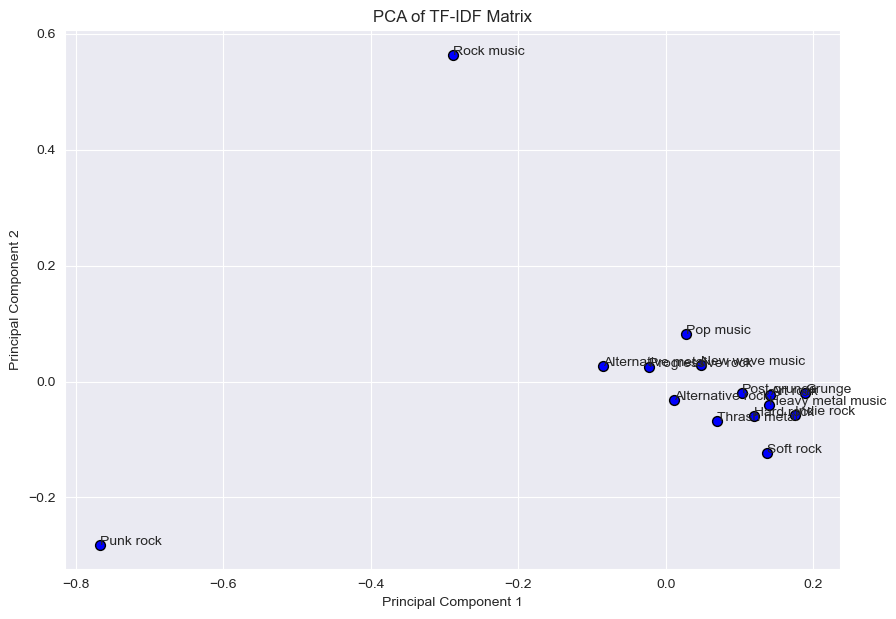

**Figure 3.1:** *PCA of the TF-IDF Matrix for the documents of the communities made by genres.*

In [23]:
communities_tfidf["genre"].plot_pca(top_15_genres)
display(Markdown("**Figure 3.1:** *PCA of the TF-IDF Matrix for the documents of the communities made by genres.*"))

From this we can observe that the punk genre is really eccentric from all the other genres. However, the other genres share similar vocabulary.


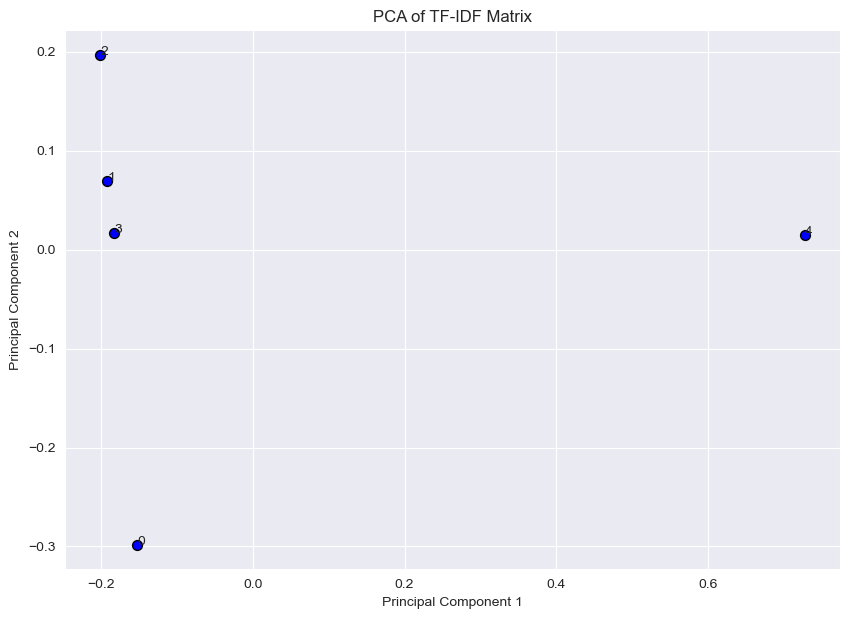

**Figure 3.1:** *PCA of the TF-IDF Matrix for the documents of the communities made by Louvain-algorithm.*

In [24]:
communities_tfidf["louvain"].plot_pca(range(len(louvain_communities_sorted[:15])))
display(Markdown("**Figure 3.1:** *PCA of the TF-IDF Matrix for the documents of the communities made by Louvain-algorithm.*"))

In [16]:
top_n = 5

# Apply to each row - get top N column names only
top_words_per_doc_genre = (communities_tfidf["genre"].tfidf_df.apply(lambda row: list(row.nlargest(top_n).index), axis=1))

# Convert to a more readable format
result = pd.DataFrame({
    'document': top_15_genres,
    'top_words': top_words_per_doc_genre
})

print("The 15 biggest communities formed by genre have these 5 words with the biggest TF-IDF score in their wikipedia page texts:")
print(result)

The 15 biggest communities formed by genre have these 5 words with the biggest TF-IDF score in their wikipedia page texts:
             document                               top_words
0   Alternative metal      [album, band, song, release, tour]
1            Art rock      [band, album, release, song, tour]
2         Post-grunge      [band, album, tour, release, rock]
3    Alternative rock      [album, band, release, tour, john]
4           Hard rock  [band, album, tour, release, osbourne]
5           Pop music   [album, band, gabriel, release, tour]
6           Punk rock  [align, record, richard, center, rock]
7   Heavy metal music   [band, album, release, cornell, song]
8      New wave music     [band, album, tour, duran, release]
9           Soft rock       [band, album, release, bar, song]
10             Grunge       [album, band, release, bar, song]
11   Progressive rock    [band, album, release, record, tour]
12       Thrash metal    [band, album, release, record, rock]
13       

In [17]:
top_n = 5

# Apply to each row - get top N column names only
top_words_per_doc_louvain = communities_tfidf["louvain"].tfidf_df.apply(lambda row: list(row.nlargest(top_n).index), axis=1)

# Convert to a more readable format
result = pd.DataFrame({
    'document': communities_tfidf["louvain"].tfidf_df.index,
    'top_words': top_words_per_doc_louvain
})
print("The communities formed by Louvain-algorithm have these 5 words with the biggest TF-IDF score in their wikipedia page texts:")
print(result)

The communities formed by Louvain-algorithm have these 5 words with the biggest TF-IDF score in their wikipedia page texts:
   document                                    top_words
0         0         [album, band, song, release, record]
1         1           [band, album, release, tour, song]
2         2           [band, album, release, tour, song]
3         3           [band, album, tour, release, rock]
4         4  [funkadelic, parliament, band, funk, album]


Calculating the tf-idf for documents based of the communities we can find that the top words are all the same for each community. This is due to the fact that "album" and "band" are too domain-specific and even if it occurs in every document, it occurs in such a big rate that even with the idf penalty the really high tf makes the tf-idf score high. However we can see that for punk rock and rock, the words with high tf-idf are different which further indicates that their wikipedia pages are different from other genres.


We were wondering what happens if we put these common words into the following stop_words: 'album', 'band', 'song', 'release', 'tour', 'record', 'music'

In [18]:
communities_tfidf_with_custom_stopwords = {"genre": TFIDF_Communities("genre", rock_artists_graph_communities_bygenre_list_sorted, True),
                     "louvain": TFIDF_Communities("louvain", louvain_communities_sorted, True)}

In [19]:
# Apply to each row - get top N column names only
top_words_per_doc_genre_with_custom_stopwords = (communities_tfidf_with_custom_stopwords["genre"].tfidf_df.apply(lambda row: list(row.nlargest(top_n).index), axis=1))

# Convert to a more readable format
result = pd.DataFrame({
    'document': top_15_genres,
    'top_words': top_words_per_doc_genre_with_custom_stopwords
})

print("The 15 biggest communities formed by genre have these 5 words with the biggest TF-IDF score in their wikipedia page texts by adding our custom stopwords:")
print(result)

The 15 biggest communities formed by genre have these 5 words with the biggest TF-IDF score in their wikipedia page texts by adding our custom stopwords:
             document                                         top_words
0   Alternative metal                   [rock, year, single, new, time]
1            Art rock                    [rock, bar, single, new, year]
2         Post-grunge                 [rock, new, guitar, single, lead]
3    Alternative rock                 [john, bar, ferry, single, vocal]
4           Hard rock        [osbourne, metal, sabbath, new, metallica]
5           Pop music           [gabriel, rock, anderson, new, genesis]
6           Punk rock             [align, richard, center, rock, holly]
7   Heavy metal music            [cornell, rock, bar, new, evanescence]
8      New wave music                   [duran, new, ant, dury, single]
9           Soft rock                  [bar, single, rock, color, till]
10             Grunge                  [bar, single, c

In [20]:
top_n = 5

# Apply to each row - get top N column names only
top_words_per_doc_louvain_with_custom_stopwords = communities_tfidf_with_custom_stopwords["louvain"].tfidf_df.apply(lambda row: list(row.nlargest(top_n).index), axis=1)

# Convert to a more readable format
result = pd.DataFrame({
    'document': communities_tfidf_with_custom_stopwords["louvain"].tfidf_df.index,
    'top_words': top_words_per_doc_louvain_with_custom_stopwords
})
print("The communities formed by Louvain-algorithm have these 5 words with the biggest TF-IDF score in their wikipedia page texts by adding our custom stopwords:")
print(result)

The communities formed by Louvain-algorithm have these 5 words with the biggest TF-IDF score in their wikipedia page texts by adding our custom stopwords:
   document                                   top_words
0         0            [rock, year, single, new, align]
1         1             [single, rock, new, bar, color]
2         2               [rock, bar, color, new, till]
3         3           [rock, new, align, guitar, vocal]
4         4  [funkadelic, parliament, funk, stone, sly]


We can see that for some genres the high tf-idf words are different. There are some genres, such as Soft rock and Grunge where the words are the same, but there is some more differentiation than before we added our own custom stop words. Furthermore, for the Louvain-algorithm communities they are more different and can be separated with the words little more than in the genre documents.

## Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

**Figure 3.3:** *TF-IDF Wordcloud of the communities made by genres.*

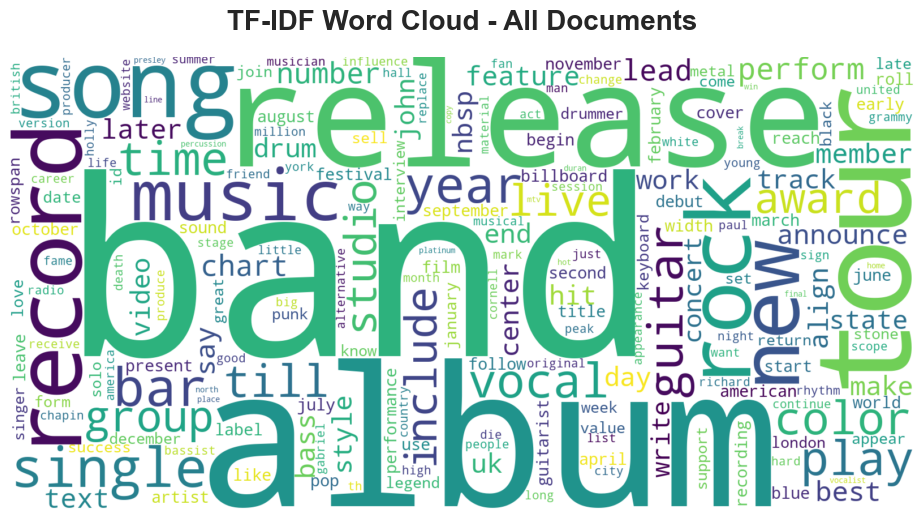

In [33]:
communities_tfidf["genre"].plot_wordcloud()
display(Markdown("**Figure 3.3:** *TF-IDF Wordcloud of the communities made by genres.*"))


**Figure 3.4:** *TF-IDF Wordcloud of the communities made by Louvain-algorithm.*

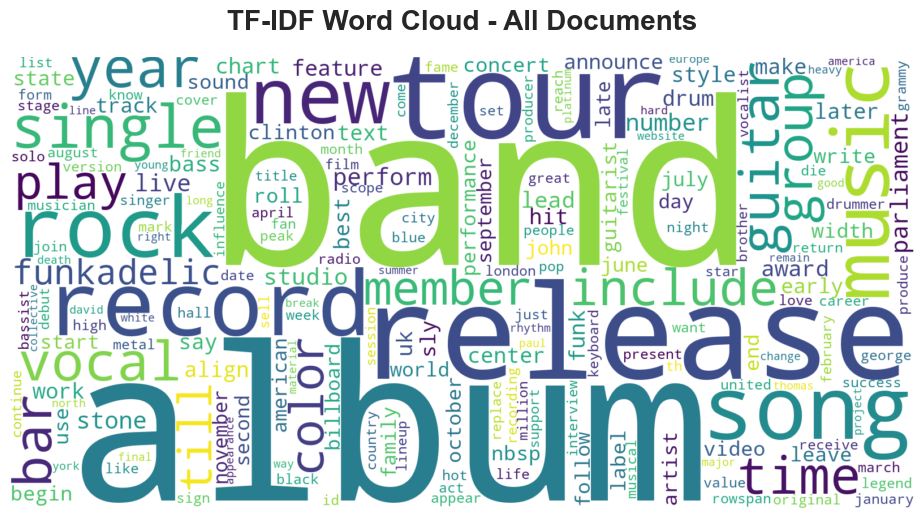

In [34]:
communities_tfidf["louvain"].plot_wordcloud()
display(Markdown("**Figure 3.4:** *TF-IDF Wordcloud of the communities made by Louvain-algorithm.*"))


In [27]:
confusion_matrix

array([[51,  2,  3, 10,  0,  6, 14],
       [ 9, 36,  2,  6,  0,  3,  0],
       [ 2, 22, 13,  0, 10,  2,  0],
       [ 9,  1, 30,  2,  6,  4,  1],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0]])

From the wordcloud we can see that the first three biggest words: band, album, release are the same for both community types. The two wordcloud does not have that much difference, which means that the artists wikipedia pages share more or less the same words.

Another reason the two wordclouds are similar is that all the louvain community contains artists from multiple genres, so we blend the different genres in one document.

# Part 4: Sentiment of the artists and communities

## Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.

First we have to download the

In [28]:
word_scores = {}
with open("labMIT-1.0.txt", 'r', encoding='utf-8') as f:
            next(f)
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 3:
                    word = parts[0].lower()
                    happiness_score = float(parts[2])
                    word_scores[word] = happiness_score

In [29]:
import nltk

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dhanna/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dhanna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/dhanna/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/dhanna/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

Here we went through all the artists' json file and calculated the sentiment score for their wikipedia pages.

In [30]:
import os
from sentiment_analysis import calculate_sentiment

sentiment_scores_of_pages = {}

items = os.listdir("wikipedia_pages")
files = [f for f in items if os.path.isfile(os.path.join("wikipedia_pages", f))]
print(f"Found {len(files)} files:")
for file in files:
    if file.endswith(".json"):
        text = get_wiki_text("wikipedia_pages/" + file)
        sentiment = calculate_sentiment(text, word_scores)['mean']
        sentiment_scores_of_pages[file] = sentiment

Found 717 files:


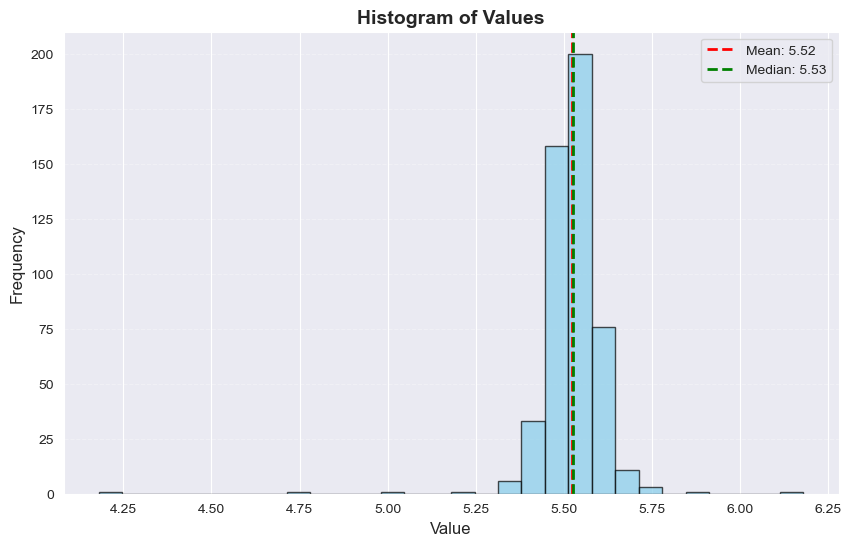

In [31]:
import numpy as np
from matplotlib import pyplot as plt
data = list(sentiment_scores_of_pages.values())
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, edgecolor='black', alpha=0.7, color='skyblue')

# Add labels and title
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Values', fontsize=14, fontweight='bold')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Display statistics on the plot
mean_val = np.mean(data)
median_val = np.median(data)
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
plt.legend()
display(Markdown("**Figure 4.1:** *Histogram of the sentiment analysis of the artists' wikipedia pages.*"))

We can see that all the artists' wikipedia pages have a sentiment score between 5.3 and 6. This means the sentiment of their wikipedia pages don't vary that much. All of them are pretty neutral.

## Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

In [38]:
communities_tfidf["genre"].calculate_sentiment_scores(word_scores, top_15_genres)

In [39]:
communities_tfidf["genre"].sentiment_scores_of_documents

{'Alternative metal': 5.567022226232368,
 'Art rock': 5.588733740312342,
 'Post-grunge': 5.548041870355603,
 'Alternative rock': 5.578170985805444,
 'Hard rock': 5.502258018970851,
 'Pop music': 5.549834318103228,
 'Punk rock': 5.525225522151611,
 'Heavy metal music': 5.550994823642711,
 'New wave music': 5.58259809183065,
 'Soft rock': 5.5783100118583775,
 'Grunge': 5.604940623845463,
 'Progressive rock': 5.5513837996122035,
 'Thrash metal': 5.515639796620942,
 'Indie rock': 5.590647702670195,
 'Rock music': 5.554151669020221}

We can see that all the genres' documents have more or less the same sentiments. This make sense since all the artists' wikipedia page sentimental analysis were between 5.3 and 6 and these documents are their concatenated texts. These may be because wikipedia have a rather neutral, more formal tone.

In [44]:
communities_tfidf["louvain"].calculate_sentiment_scores(word_scores, list(range(len(communities_tfidf["louvain"].documents))))

In [45]:
communities_tfidf["louvain"].sentiment_scores_of_documents

{1: 5.571217983169768,
 2: 5.54835611533405,
 3: 5.541100873007458,
 4: 5.525751703862087,
 0: 5.561589096323445}

For the Louvain-algorithm documents the communities' documents also have more or less the same sentiments around 5.5. This make sense since all the artists' wikipedia page sentimental analysis were between 5.3 and 6 and these documents are their concatenated texts.

### Our overall conclusions

By performing the tf-idf of the documents and looking at the words with the highes tf-idf we can also state that the artists' wikipedia pages are really similar. However, this should not be that surprising as all the wikipedia pages are about artists, their life, albums, tours, etc. The word clouds also strengthen this statement as they are quite similar whether we look at the one formed by the louvain-algorithm or the genres.
After adding our custom stopwords to the tf-idf calculations, we got different result, however those words had many overlapping as well for both communities formed by genre and Louvain-algorithm.
The artists wikipedia pages have a similar neutral tone, so doing a sentiment analysis on them does not say a lot about these texts. As all the artists' wikipedia page are between the range 5.3 and 6, performing a sentiment analysis on the documents made using the communities resulted with the same values.


### Some addition
As there were a lot of code, we arranged some of the codes into different .py files.
Unfortunatelly, we had some issues with the version of the powerlaw library. One of us used powerlaw 1.5 and the other 1.4.4. Unfortunatelly, this code only works with powerlaw 1.5 version.
We used LLM in the get_artist_genres.py where we read out the genres of the artists from the json files. We used it as it was advised us to use it in Week7.
We also used LLM for extracting Wikipedia text from the JSON data in the extract_wikipedia_text_to_string.py. We used it for text cleaning, and with cutting out the references section
We tested these code snippets with multiple examples to make sure if they really work.

We all contributed equally to the assignment.

Enikő Horninger: Part 1
Hoang Anh Do, Bálint Kostyál: Part 2, 3, 4